## Классические алгоритмы без ансамблирования
В этом ноутбуке вам нужно обучить модели на датасете классификации из предыдущего ноутбука и сравнить результаты. Вам будет предоставлен baseline, на основе которого вы будете доделывать предсказывающие модели. Оценка лабы будет зависеть от ROC-AUC на тестовых данных по следующим критериям:
\
AUC - на тестовых данных
- $AUC \leq 0.75$ - 0 баллов
- $0.75 < AUC \leq 0.76$ - 2 балла
- $0.76 < AUC \leq 0.77$ - 4 балла
- $0.77 < AUC \leq 0.78$ - 6 баллов
- $0.78 < AUC \leq 0.79$ - 8 баллов
- $AUC > 0.79$ - 10 баллов

\
В этой работе запрещено использовать ансамбли моделей (лес, бустинги и т.д.)!

In [358]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.8 MB/s eta 0:00:00


In [359]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import roc_auc_score, precision_score, recall_score, roc_curve, accuracy_score

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [360]:
data = pd.read_csv('german.csv', sep=';')
print(data.head())

X = data.iloc[:, 1:].to_numpy()
y = data.iloc[:, 0].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

   Creditability  Account_Balance  Duration_of_Credit_monthly  \
0              1                1                          18   
1              1                1                           9   
2              1                2                          12   
3              1                1                          12   
4              1                1                          12   

   Payment_Status_of_Previous_Credit  Purpose  Credit_Amount  \
0                                  4        2           1049   
1                                  4        0           2799   
2                                  2        9            841   
3                                  4        0           2122   
4                                  4        0           2171   

   Value_Savings_Stocks  Length_of_current_employment  Instalment_per_cent  \
0                     1                             2                    4   
1                     1                             3               

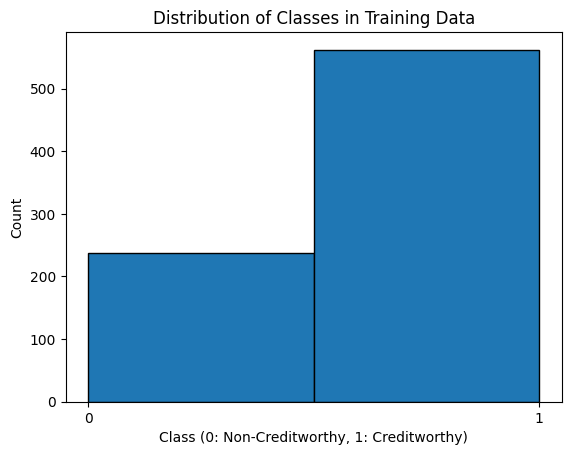

In [361]:
plt.hist(y_train, bins=2, edgecolor='k')
plt.xticks([0, 1])
plt.xlabel('Class (0: Non-Creditworthy, 1: Creditworthy)')
plt.ylabel('Count')
plt.title('Distribution of Classes in Training Data')
plt.show()

In [362]:
#масштабируем данные
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [363]:
#оптимизируем гиперпараметры
import optuna


def objective_knn(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 800)
    leaf_size = trial.suggest_int('leaf_size', 1, 800)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    p = trial.suggest_int('p', 1, 2)

    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, p=p, leaf_size=leaf_size)
    model.fit(X_train_scaled, y_train)

    y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    return roc_auc


def objective_dt(trial):
    max_depth = trial.suggest_int('max_depth', 1, 200)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 200)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 200)

    model = DecisionTreeClassifier(max_depth=max_depth,
                                   min_samples_split=min_samples_split,
                                   min_samples_leaf=min_samples_leaf,
                                   random_state=42)
    model.fit(X_train, y_train)

    y_pred_prob = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    return roc_auc


def objective_lr(trial):
    C = trial.suggest_float('C', 1e-4, 10.0, log=True)
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'])

    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
    max_iter = trial.suggest_int('max_iter', 100, 500)

    model = LogisticRegression(
        C=C,
        solver=solver,
        class_weight=class_weight,
        max_iter=max_iter
    )
    model.fit(X_train_scaled, y_train)

    y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    return roc_auc

study_lr = optuna.create_study(direction='maximize')
study_lr.optimize(objective_lr, n_trials=100)

print("Best ROC-AUC for LogisticRegression: ", study_lr.best_value)
print("Best hyperparameters for LogisticRegression: ", study_lr.best_params)

study_dt = optuna.create_study(direction='maximize')
study_dt.optimize(objective_dt, n_trials=50)

print("Best ROC-AUC for DecisionTreeClassifier: ", study_dt.best_value)
print("Best hyperparameters for DecisionTreeClassifier: ", study_dt.best_params)

study_knn = optuna.create_study(direction='maximize')
study_knn.optimize(objective_knn, n_trials=50)

print("Best ROC-AUC for KNeighborsClassifier: ", study_knn.best_value)
print("Best hyperparameters for KNeighborsClassifier: ", study_knn.best_params)

[I 2024-10-23 16:17:38,379] A new study created in memory with name: no-name-421ea960-e414-4c85-810e-a00dc748b2a5
[I 2024-10-23 16:17:38,411] Trial 0 finished with value: 0.7882187938288919 and parameters: {'C': 0.38406914453426, 'solver': 'saga', 'class_weight': 'balanced', 'max_iter': 221}. Best is trial 0 with value: 0.7882187938288919.
[I 2024-10-23 16:17:38,437] Trial 1 finished with value: 0.7891538101916782 and parameters: {'C': 0.0037114798221341695, 'solver': 'lbfgs', 'class_weight': 'balanced', 'max_iter': 172}. Best is trial 1 with value: 0.7891538101916782.
[I 2024-10-23 16:17:38,482] Trial 2 finished with value: 0.788218793828892 and parameters: {'C': 1.3579640871054715, 'solver': 'saga', 'class_weight': 'balanced', 'max_iter': 225}. Best is trial 1 with value: 0.7891538101916782.
[I 2024-10-23 16:17:38,510] Trial 3 finished with value: 0.7861150070126227 and parameters: {'C': 0.0003261220979591886, 'solver': 'lbfgs', 'class_weight': None, 'max_iter': 408}. Best is trial 1

Best ROC-AUC for LogisticRegression:  0.7940626460963067
Best hyperparameters for LogisticRegression:  {'C': 0.01991588987309493, 'solver': 'liblinear', 'class_weight': None, 'max_iter': 439}


[I 2024-10-23 16:17:50,042] Trial 6 finished with value: 0.7473702664796633 and parameters: {'max_depth': 151, 'min_samples_split': 97, 'min_samples_leaf': 135}. Best is trial 0 with value: 0.787400654511454.
[I 2024-10-23 16:17:50,076] Trial 7 finished with value: 0.7422861150070126 and parameters: {'max_depth': 107, 'min_samples_split': 181, 'min_samples_leaf': 59}. Best is trial 0 with value: 0.787400654511454.
[I 2024-10-23 16:17:50,098] Trial 8 finished with value: 0.7536816269284712 and parameters: {'max_depth': 135, 'min_samples_split': 166, 'min_samples_leaf': 110}. Best is trial 0 with value: 0.787400654511454.
[I 2024-10-23 16:17:50,121] Trial 9 finished with value: 0.7405913978494623 and parameters: {'max_depth': 108, 'min_samples_split': 141, 'min_samples_leaf': 44}. Best is trial 0 with value: 0.787400654511454.
[I 2024-10-23 16:17:50,216] Trial 10 finished with value: 0.712599345488546 and parameters: {'max_depth': 39, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best 

Best ROC-AUC for DecisionTreeClassifier:  0.8043478260869565
Best hyperparameters for DecisionTreeClassifier:  {'max_depth': 25, 'min_samples_split': 87, 'min_samples_leaf': 19}


[I 2024-10-23 16:17:53,396] Trial 5 finished with value: 0.7701612903225806 and parameters: {'n_neighbors': 558, 'leaf_size': 467, 'weights': 'uniform', 'p': 2}. Best is trial 3 with value: 0.7821411874707807.
[I 2024-10-23 16:17:53,429] Trial 6 finished with value: 0.7719728845254792 and parameters: {'n_neighbors': 75, 'leaf_size': 735, 'weights': 'distance', 'p': 2}. Best is trial 3 with value: 0.7821411874707807.
[I 2024-10-23 16:17:53,505] Trial 7 finished with value: 0.7701028517999065 and parameters: {'n_neighbors': 262, 'leaf_size': 483, 'weights': 'uniform', 'p': 2}. Best is trial 3 with value: 0.7821411874707807.
[I 2024-10-23 16:17:53,563] Trial 8 finished with value: 0.7891538101916784 and parameters: {'n_neighbors': 473, 'leaf_size': 64, 'weights': 'distance', 'p': 1}. Best is trial 8 with value: 0.7891538101916784.
[I 2024-10-23 16:17:53,594] Trial 9 finished with value: 0.7717975689574568 and parameters: {'n_neighbors': 226, 'leaf_size': 714, 'weights': 'uniform', 'p': 2}

Best ROC-AUC for KNeighborsClassifier:  0.8016596540439459
Best hyperparameters for KNeighborsClassifier:  {'n_neighbors': 639, 'leaf_size': 206, 'weights': 'distance', 'p': 1}


In [387]:
# Создание модели Logistic Regression
logistic_regression_model = LogisticRegression(C=0.01991588987309493, solver='liblinear', penalty='l2')
logistic_regression_model.fit(X_train_scaled, y_train)

# Создание модели Decision Tree
decision_tree_model = DecisionTreeClassifier(max_depth=85, min_samples_split=95, min_samples_leaf=18)
decision_tree_model.fit(X_train, y_train)

# Создание модели K-Nearest Neighbors
knn_model = KNeighborsClassifier(n_neighbors=639, leaf_size = 205, p=1, weights='distance')
knn_model.fit(X_train_scaled, y_train)

KNeighborsClassifier(leaf_size=205, n_neighbors=639, p=1, weights='distance')

In [388]:
y_prob_logistic = logistic_regression_model.predict_proba(X_test_scaled)[:, 1]
y_prob_decision_tree = decision_tree_model.predict_proba(X_test)[:, 1]
y_prob_knn = knn_model.predict_proba(X_test_scaled)[:, 1]

y_pred_logistic = logistic_regression_model.predict(X_test_scaled)
y_pred_decision_tree = decision_tree_model.predict(X_test)
y_pred_knn = knn_model.predict(X_test_scaled)

accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
accuracy_decision_tree = accuracy_score(y_test, y_pred_decision_tree)
accuracy_knn = accuracy_score(y_test, y_pred_knn)

roc_auc_logistic = roc_auc_score(y_test, y_prob_logistic)
roc_auc_decision_tree = roc_auc_score(y_test, y_prob_decision_tree)
roc_auc_knn = roc_auc_score(y_test, y_prob_knn)

precision_logistic = precision_score(y_test, y_pred_logistic)
precision_decision_tree = precision_score(y_test, y_pred_decision_tree)
precision_knn = precision_score(y_test, y_pred_knn)

recall_logistic = recall_score(y_test, y_pred_logistic)
recall_decision_tree = recall_score(y_test, y_pred_decision_tree)
recall_knn = recall_score(y_test, y_pred_knn)

print(f'Accuracy of Logistic Regression: {accuracy_logistic}')
print(f'Accuracy of Decision Tree: {accuracy_decision_tree}')
print(f'Accuracy of K-Nearest Neighbors: {accuracy_knn}')

print(f'ROC AUC of Logistic Regression: {roc_auc_logistic}')
print(f'ROC AUC of Decision Tree: {roc_auc_decision_tree}')
print(f'ROC AUC of K-Nearest Neighbors: {roc_auc_knn}')

print(f'Precision of Logistic Regression: {precision_logistic}')
print(f'Precision of Decision Tree: {precision_decision_tree}')
print(f'Precision of K-Nearest Neighbors: {precision_knn}')

print(f'Recall of Logistic Regression: {recall_logistic}')
print(f'Recall of Decision Tree: {recall_decision_tree}')
print(f'Recall of K-Nearest Neighbors: {recall_knn}')

Accuracy of Logistic Regression: 0.77
Accuracy of Decision Tree: 0.775
Accuracy of K-Nearest Neighbors: 0.69
ROC AUC of Logistic Regression: 0.7940626460963067
ROC AUC of Decision Tree: 0.8043478260869565
ROC AUC of K-Nearest Neighbors: 0.8016596540439459
Precision of Logistic Regression: 0.7948717948717948
Precision of Decision Tree: 0.7818181818181819
Precision of K-Nearest Neighbors: 0.69
Recall of Logistic Regression: 0.8985507246376812
Recall of Decision Tree: 0.9347826086956522
Recall of K-Nearest Neighbors: 1.0


## Экспериментируйте
Для получения лучшего качества придется поэкспериментировать. Подсказка: попробуйте оптимизировать гиперпараметры модели